In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Selecting Dataset Folder Paths
dir_ = Path('/content/drive/MyDrive/Image_Classification/data/train')
filepaths = list(dir_.glob(r'**/*.png'))
# Mapping the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Paths & labels femalee eyes
filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating...
df = pd.concat([filepaths, labels], axis=1)
df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

In [ ]:
trainset_df,testset_df = train_test_split(df, train_size = 0.90, random_state = 42)
display(trainset_df.head())
testset_df.head()

,File,Label
4299,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
5090,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
2145,/content/drive/MyDrive/Image_Classification/da...,train_vehicles
11406,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
4974,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles


,File,Label
12456,/content/drive/MyDrive/Image_Classification/da...,train_vehicles
10557,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
10042,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
7810,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
4864,/content/drive/MyDrive/Image_Classification/da...,train_vehicles


In [ ]:
#converting the Label to a numeric format for testing later...
LE = LabelEncoder()
y_test = LE.fit_transform(testset_df["Label"])

In [ ]:
# Viewing data in training dataset
print('Training Dataset:')
print(f'Number of images: {trainset_df.shape[0]}')
print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')
print(f'Number of images: {testset_df.shape[0]}')
print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 11264
Number of images with malee eyes: 5841
Number of images with femalee eyes: 5423

Test Dataset:
Number of images: 1252
Number of images with malee eyes: 643
Number of images with femalee eyes: 609



In [ ]:
#rescale - Transform image size (normalization of data)
#shear_range - Random geometric transformations
#zoom_range - Images that will be zoomed
#rotation_range - Degree of image rotation
#width_shift_range - Image Width Change Range
#height_shift_range - Image height change range
#horizontal_flip - Rotate images horizontally
#vertical_flip - Rotate images vertically
#validation_split - Images that have been reserved for validation (0-1)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#Directory of training, validation and test images
'''dataframe - Dataframe containing the images directory
x_col - Column name containing the images directory
y_col - Name of the column containing what we want to predict
target_size - size of the images (remembering that it must be the same size as the input layer)
color_mode - RGB color standard
class_mode - binary class mode
batch_size - batch size
shuffle - Shuffle the data
seed - optional random seed for the shuffle
subset - Subset of data being training and validation (only used if using validation_split in ImageDataGenerator)'''
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 100,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 100,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 100)

print('Data generators are ready!')


Preparing the training dataset ...
Found 10138 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1126 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 1252 validated image filenames belonging to 2 classes.
Data generators are ready!


In [ ]:
'''monitor - Metrics that will be monitored
patience - Number of times without improvement in the model, after these times the training is stopped
restore_best_weights - Restores best weights if training is interrupted'''
# Callbacks
#cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

'monitor - Metrics that will be monitored\npatience - Number of times without improvement in the model, after these times the training is stopped\nrestore_best_weights - Restores best weights if training is interrupted'

In [ ]:
#Construction of model MobileNet
'''Step 1 - Base model creation
input_shape - Setting the height/width and RGB channels (75, 75, 3)
include_top - Fully connected layer will not be included on top
weights - Pre-training using imagenet'''
CNN_base_mobilenet = MobileNet(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in CNN_base_mobilenet.layers:
  layer.trainable = False

In [ ]:
'''Step 2 - Dense Neural Networks
Dense - All connected neurons
units - Number of neurons that are part of the hidden layer
activation - Activation function that will be inserted
Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)'''
CNN_mobilenet = Sequential()
CNN_mobilenet.add(BatchNormalization(input_shape = (75, 75, 3)))
CNN_mobilenet.add(CNN_base_mobilenet)
CNN_mobilenet.add(BatchNormalization())
CNN_mobilenet.add(GlobalAveragePooling2D())
CNN_mobilenet.add(Dropout(0.5))
CNN_mobilenet.add(Dense(1, activation = 'sigmoid'))

CNN_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 75, 75, 3)        12        
 ormalization)                                                   
                                                                 
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 2, 2, 1024)       4096      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [ ]:
'''Step 3 - Model compilation and training
Compile parameters:
optimizer - descent of the gradient and descent of the stochastic gradient
 loss - Loss function (binary_crossentropy as there is only one exit)
 metrics - Evaluation metrics (obs - more than one can be placed)
 Fit parameters:

 train_data - training database
 epochs - number of seasons
 validation_data - test database
 callbacks - Using EarlyStopping
 validation_steps - number of images to validation'''
 # Compilation
CNN_mobilenet.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_mobilenet_history = CNN_mobilenet.fit(training_set, epochs = 35, validation_data = validation_set, )
#callbacks = cb
# End of Time Counting
end = dt.datetime.now()
time_CNN_mobilenet = end - start
print ('\nTraining and validation time: ', time_CNN_mobilenet)

Epoch 1/35
102/102 [==============================] - 1536s 14s/step - loss: 0.2546 - accuracy: 0.8946 - val_loss: 0.1304 - val_accuracy: 0.9512
Epoch 2/35
102/102 [==============================] - 36s 350ms/step - loss: 0.1050 - accuracy: 0.9625 - val_loss: 0.0779 - val_accuracy: 0.9734
Epoch 3/35
102/102 [==============================] - 36s 348ms/step - loss: 0.0889 - accuracy: 0.9696 - val_loss: 0.0524 - val_accuracy: 0.9831
Epoch 4/35
102/102 [==============================] - 35s 344ms/step - loss: 0.0767 - accuracy: 0.9734 - val_loss: 0.0526 - val_accuracy: 0.9813
Epoch 5/35
102/102 [==============================] - 35s 348ms/step - loss: 0.0716 - accuracy: 0.9762 - val_loss: 0.0595 - val_accuracy: 0.9822
Epoch 6/35
102/102 [==============================] - 37s 366ms/step - loss: 0.0666 - accuracy: 0.9758 - val_loss: 0.0432 - val_accuracy: 0.9849
Epoch 7/35
102/102 [==============================] - 35s 341ms/step - loss: 0.0571 - accuracy: 0.9804 - val_loss: 0.0392 - val_ac

In [ ]:
import matplotlib.pyplot as plot
import tensorflow as tf
import matplotlib.pyplot as plt

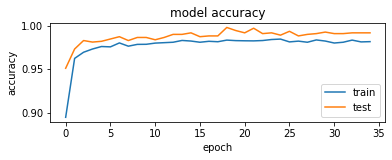

In [ ]:
plot.subplot(2,1,1)
plot.plot(CNN_mobilenet_history.history['accuracy'])
plot.plot(CNN_mobilenet_history.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

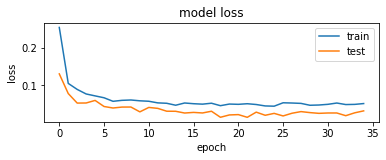

In [ ]:
plot.subplot(2,1,2)
plot.plot(CNN_mobilenet_history.history['loss'])
plot.plot(CNN_mobilenet_history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

In [ ]:
model_json = CNN_mobilenet.to_json()
with open("/content/drive/MyDrive/Image_Classification/MobileNet Model/MobileNet.json", "w") as json_file:
  json_file.write(model_json)
  CNN_mobilenet.save("/content/drive/MyDrive/Image_Classification/MobileNet Model/MobileNet.h5")
  print("Saved model to disk")
  CNN_mobilenet.save_weights("/content/drive/MyDrive/Image_Classification/MobileNet Model/MobileNet.h5")

Saved model to disk
